# VMWare CAP Hackathon 2021
## Staff Management Tool
This notebbok aims to create a tool for contact centre staffing to predict the number of employees to cater to the incoming service requests to maximise customer satisfaction.

#Preprocessing Data

In [2]:
import pandas as pd
import datetime

df = pd.read_excel('/content/drive/MyDrive/vmware.xlsx', sheet_name = None)
FebCalls = df['Feb-Calls']
FebChats = df['Feb-Chats']
MarCalls = df['March-Calls']
MarChats = df['March-Chats']

In [3]:
CallDataset = pd.DataFrame(columns = ['DateTime', 'CallVolume'])
for j in range(1, 29):
    for i in range(24):
        CallDataset = CallDataset.append([{
            'DateTime': datetime.datetime.combine(FebCalls.columns[j], FebCalls.iloc[i, 0]),
            'CallVolume': int(FebCalls.iloc[i, j])
        }])
for j in range(1, 32):
    for i in range(24):
        CallDataset = CallDataset.append([{
            'DateTime': datetime.datetime.combine(MarCalls.columns[j], MarCalls.iloc[i, 0]),
            'CallVolume': int(MarCalls.iloc[i, j])
        }])

In [4]:
ChatDataset = pd.DataFrame(columns = ['DateTime', 'ChatVolume'])
for j in range(1, 29):
    for i in range(24):
        ChatDataset = ChatDataset.append([{
            'DateTime': datetime.datetime.combine(FebChats.columns[j], FebChats.iloc[i, 0]),
            'ChatVolume': int(FebChats.iloc[i, j])
        }])
for j in range(1, 32):
    for i in range(24):
        ChatDataset = ChatDataset.append([{
            'DateTime': datetime.datetime.combine(MarChats.columns[j], MarChats.iloc[i, 0]),
            'ChatVolume': int(MarChats.iloc[i, j])
        }])

In [5]:
ChatDataset.reset_index(drop=True, inplace=True)
CallDataset.reset_index(drop=True, inplace=True)
CombinedDataset = pd.concat([CallDataset, ChatDataset['ChatVolume']], axis=1)

In [6]:
df = CombinedDataset
df.head()

,DateTime,CallVolume,ChatVolume
0,2021-02-01 06:30:00,3,12
1,2021-02-01 07:30:00,5,4
2,2021-02-01 08:30:00,9,15
3,2021-02-01 09:30:00,17,17
4,2021-02-01 10:30:00,9,36


In [7]:
df.DateTime = pd.to_datetime(df.DateTime)
df = df.set_index('DateTime')
df.head()

,CallVolume,ChatVolume
DateTime,,
2021-02-01 06:30:00,3,12
2021-02-01 07:30:00,5,4
2021-02-01 08:30:00,9,15
2021-02-01 09:30:00,17,17
2021-02-01 10:30:00,9,36


#Importing Libraries


In [8]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas.util.testing as tm

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  # Remove the CWD from sys.path while we load stuff.


In [9]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

#ADF and KPSS Test Functions

In [10]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [11]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

#Plotting ACF and PACF Plots

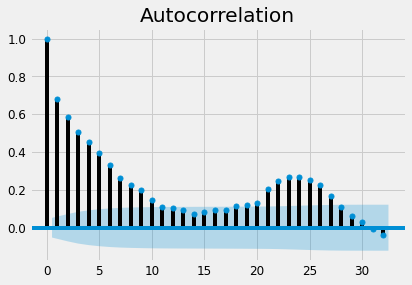

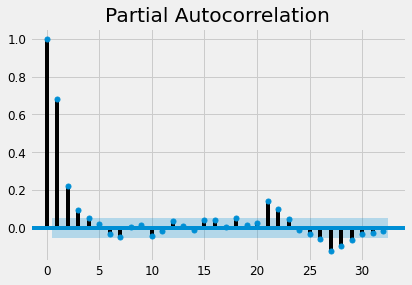

In [12]:
plot_acf(df.CallVolume)
matplotlib.pyplot.show()
plot_pacf(df.CallVolume)
matplotlib.pyplot.show()


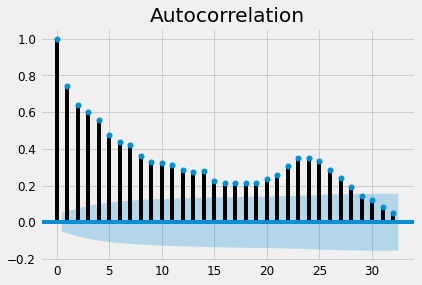

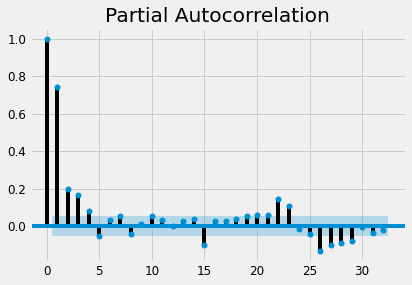

In [13]:
plot_acf(df.ChatVolume)
matplotlib.pyplot.show()
plot_pacf(df.ChatVolume)
matplotlib.pyplot.show()


#Checking for Stationarity

In [14]:
print(adf_test(df.CallVolume))
print(kpss_test(df.CallVolume))

Results of Dickey-Fuller Test:
Test Statistic                   -4.271113
p-value                           0.000498
#Lags Used                       22.000000
Number of Observations Used    1393.000000
Critical Value (1%)              -3.435053
Critical Value (5%)              -2.863617
Critical Value (10%)             -2.567876
dtype: float64
None
Results of KPSS Test:
Test Statistic            0.050477
p-value                   0.100000
Lags Used                24.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None


In [15]:
print(adf_test(df.ChatVolume))
print(kpss_test(df.ChatVolume))

Results of Dickey-Fuller Test:
Test Statistic                   -3.425784
p-value                           0.010111
#Lags Used                       22.000000
Number of Observations Used    1393.000000
Critical Value (1%)              -3.435053
Critical Value (5%)              -2.863617
Critical Value (10%)             -2.567876
dtype: float64
None
Results of KPSS Test:
Test Statistic            0.065138
p-value                   0.100000
Lags Used                24.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None


In [36]:
CallData = df.drop('ChatVolume', axis = 1)
ChatData = df.drop('CallVolume', axis = 1)

#Seasonal Differencing

In [37]:
CallData['AdjVol'] = CallData['CallVolume'].diff(24)

In [38]:
ChatData['AdjVol'] = ChatData['ChatVolume'].diff(24)

In [40]:
CallData = CallData.iloc[24:]

In [41]:
ChatData = ChatData.iloc[24:]

In [42]:
print(adf_test(CallData.AdjVol))

Results of Dickey-Fuller Test:
Test Statistic                -8.008638e+00
p-value                        2.232205e-12
#Lags Used                     2.400000e+01
Number of Observations Used    1.367000e+03
Critical Value (1%)           -3.435143e+00
Critical Value (5%)           -2.863657e+00
Critical Value (10%)          -2.567897e+00
dtype: float64
None


In [43]:
print(adf_test(ChatData.AdjVol))

Results of Dickey-Fuller Test:
Test Statistic                -6.813952e+00
p-value                        2.082037e-09
#Lags Used                     2.400000e+01
Number of Observations Used    1.367000e+03
Critical Value (1%)           -3.435143e+00
Critical Value (5%)           -2.863657e+00
Critical Value (10%)          -2.567897e+00
dtype: float64
None


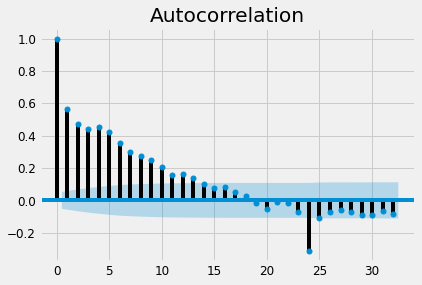

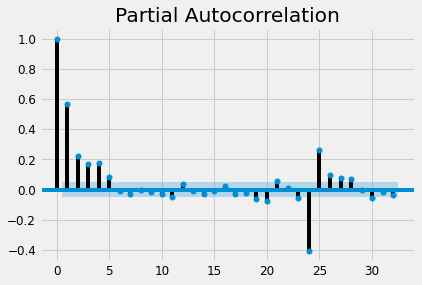

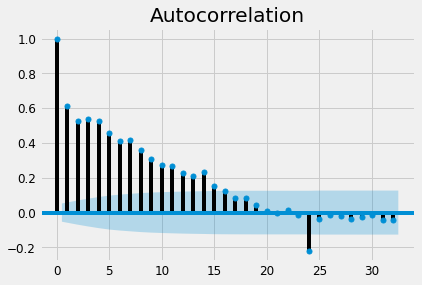

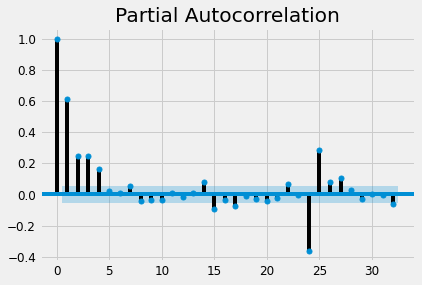

In [44]:
plot_acf(CallData.AdjVol)
matplotlib.pyplot.show()
plot_pacf(CallData.AdjVol)
matplotlib.pyplot.show()

plot_acf(ChatData.AdjVol)
matplotlib.pyplot.show()
plot_pacf(ChatData.AdjVol)
matplotlib.pyplot.show()

#Estimating Trend Differencing Order(d) and Seasonal Differencing Order(D)

In [45]:
pm.arima.ndiffs(CallData.AdjVol, alpha=0.05, test='kpss', max_d=2)

0

In [46]:
pm.arima.ndiffs(ChatData.AdjVol, alpha=0.05, test='kpss', max_d=2)

0

In [47]:
pm.arima.nsdiffs(CallData.AdjVol, 24, max_D=2, test='ocsb')

0

In [48]:
pm.arima.nsdiffs(ChatData.AdjVol, 24, max_D=2, test='ocsb')

0

#GridSearch for ARIMA Parameters

In [111]:
p = range(0, 3)
d = [0]
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA:')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))

Examples of parameter combinations for Seasonal ARIMA:
SARIMAX: (0, 0, 1) x (0, 0, 1, 24)
SARIMAX: (0, 0, 1) x (0, 0, 2, 24)
SARIMAX: (0, 0, 2) x (1, 0, 0, 24)


In [ ]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(CallData.AdjVol,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             )
#             results = mod.fit(method = 'powell')
#             print('ARIMA{}x{}24 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

Optimization terminated successfully.
         Current function value: 3.075300
         Iterations: 1
         Function evaluations: 27
ARIMA(0, 0, 0)x(0, 0, 0, 24)24 - AIC:8563.633940352154
Optimization terminated successfully.
         Current function value: 2.840458
         Iterations: 3
         Function evaluations: 83
ARIMA(0, 0, 0)x(0, 0, 1, 24)24 - AIC:7911.834824886839
Optimization terminated successfully.
         Current function value: 2.826231
         Iterations: 3
         Function evaluations: 113
ARIMA(0, 0, 0)x(0, 0, 2, 24)24 - AIC:7874.227564629664
Optimization terminated successfully.
         Current function value: 3.023531
         Iterations: 1
         Function evaluations: 24
ARIMA(0, 0, 0)x(1, 0, 0, 24)24 - AIC:8421.51155681568
Optimization terminated successfully.
         Current function value: 2.832235
         Iterations: 3
         Function evaluations: 110
ARIMA(0, 0, 0)x(1, 0, 1, 24)24 - AIC:7890.941728383299
Optimization terminated successfully.
 

In [113]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ChatData.AdjVol.astype(float),
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            )
            results = mod.fit(method = 'powell')
            print('ARIMA{}x{}24 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Optimization terminated successfully.
         Current function value: 3.919381
         Iterations: 1
         Function evaluations: 23
ARIMA(0, 0, 0)x(0, 0, 0, 24)24 - AIC:10913.556584133219
Optimization terminated successfully.
         Current function value: 3.759778
         Iterations: 2
         Function evaluations: 58
ARIMA(0, 0, 0)x(0, 0, 1, 24)24 - AIC:10471.220892527
Optimization terminated successfully.
         Current function value: 3.708975
         Iterations: 3
         Function evaluations: 115
ARIMA(0, 0, 0)x(0, 0, 2, 24)24 - AIC:10331.785736834336
Optimization terminated successfully.
         Current function value: 3.894867
         Iterations: 1
         Function evaluations: 24
ARIMA(0, 0, 0)x(1, 0, 0, 24)24 - AIC:10847.309928958593
Optimization terminated successfully.
         Current function value: 3.722464
         Iterations: 3
         Function evaluations: 114
ARIMA(0, 0, 0)x(1, 0, 1, 24)24 - AIC:10369.34086964404
Optimization terminated successfully.

#Model Selection
The Best Model will be the one with the least AIC Value.<br>
ARIMA(1, 0, 2)x(0, 0, 1, 24) is the best fit model as observed from the GridSearch performed above.

In [61]:
mod = sm.tsa.statespace.SARIMAX(CallData.AdjVol.astype(float),
                                order=(1, 0, 2),
                                seasonal_order=(0, 0, 1, 24))
results = mod.fit(method = 'powell')

Optimization terminated successfully.
         Current function value: 2.518209
         Iterations: 3
         Function evaluations: 186


In [62]:
mod1 = sm.tsa.statespace.SARIMAX(ChatData.AdjVol.astype(float),
                                order=(1, 0, 2),
                                seasonal_order=(0, 0, 1, 24))
results1 = mod1.fit(method = 'powell')

Optimization terminated successfully.
         Current function value: 3.314564
         Iterations: 3
         Function evaluations: 180


In [63]:
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               AdjVol   No. Observations:                 1392
Model:             SARIMAX(1, 0, 2)x(0, 0, [1], 24)   Log Likelihood               -3505.347
Date:                              Sat, 05 Jun 2021   AIC                           7020.695
Time:                                      19:44:16   BIC                           7046.887
Sample:                                           0   HQIC                          7030.489
                                             - 1392                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9363      0.015     63.782      0.000       0.908       0.965
ma.L1         -0.54

In [64]:
print(results1.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               AdjVol   No. Observations:                 1392
Model:             SARIMAX(1, 0, 2)x(0, 0, [1], 24)   Log Likelihood               -4613.873
Date:                              Sat, 05 Jun 2021   AIC                           9237.746
Time:                                      19:44:22   BIC                           9263.939
Sample:                                           0   HQIC                          9247.540
                                             - 1392                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9558      0.010     96.385      0.000       0.936       0.975
ma.L1         -0.51

#Residual Analysis

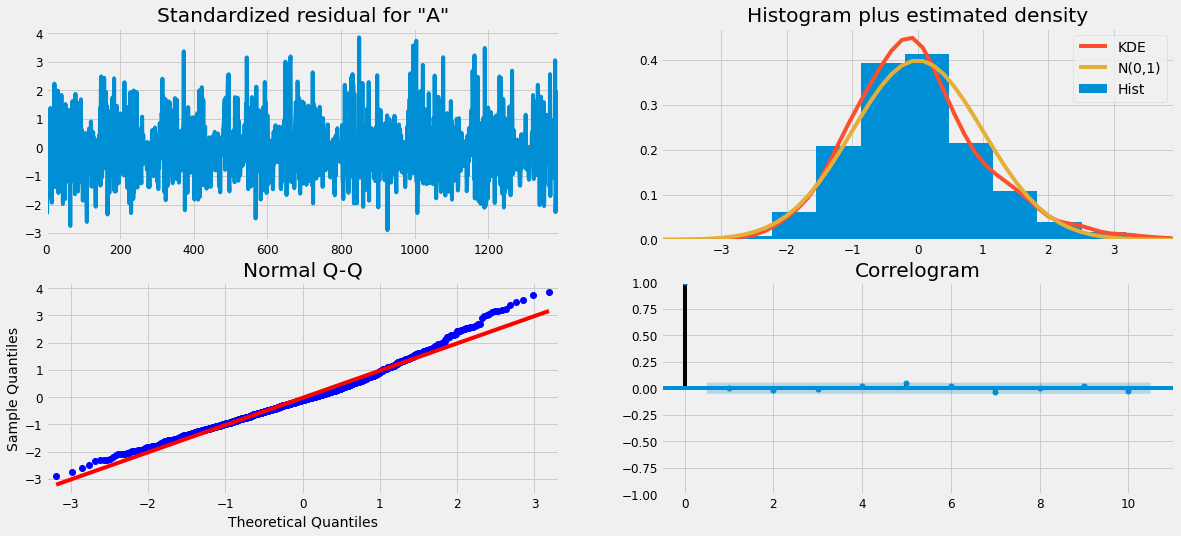

In [65]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

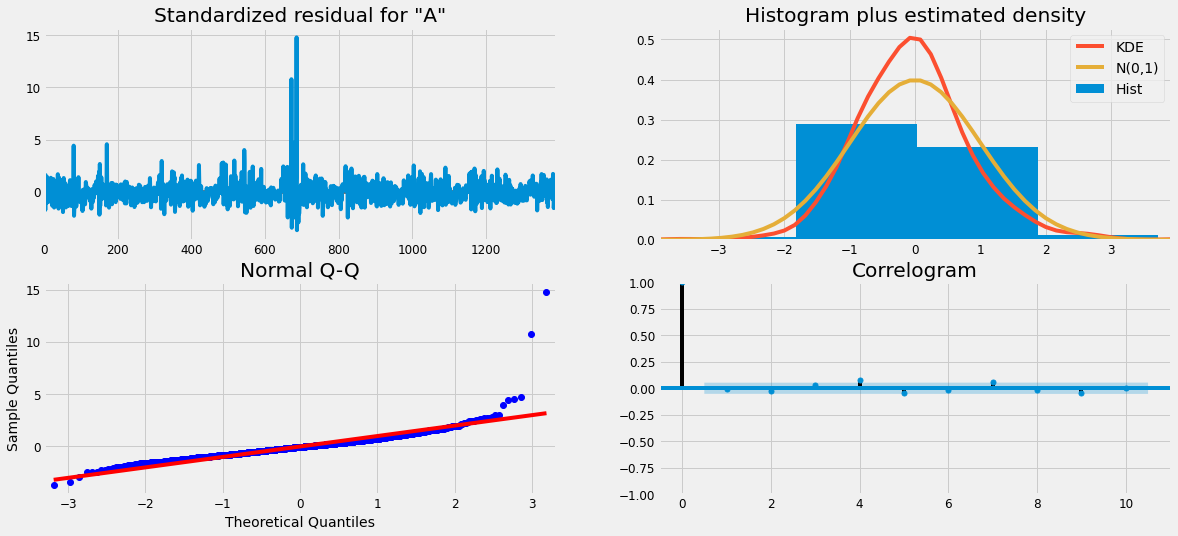

In [66]:
results1.plot_diagnostics(figsize=(18, 8))
plt.show()

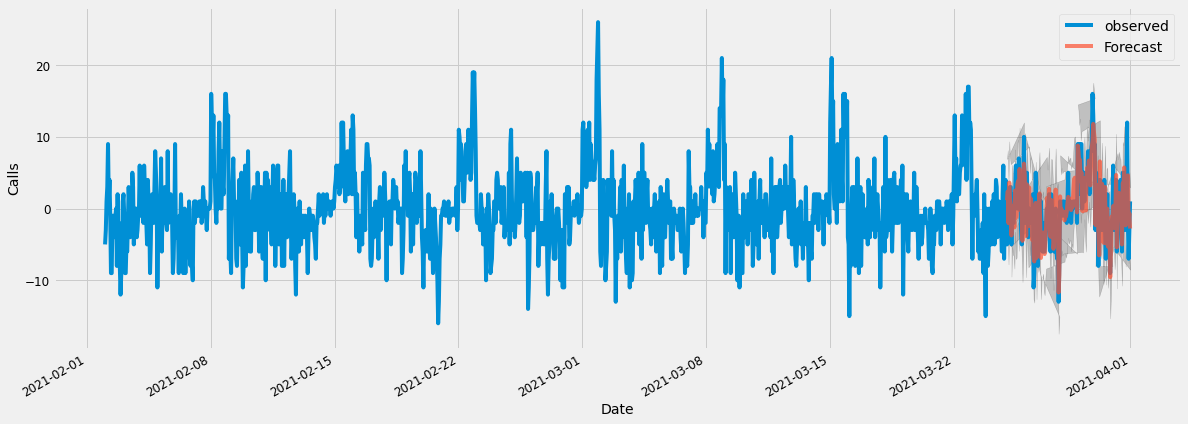

In [67]:
pred = results.get_prediction(start=pd.to_datetime('2021-03-25 06:30:00'), dynamic=False)
pred_ci = pred.conf_int()
ax = CallData['AdjVol'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(18, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Calls')
plt.legend()
plt.show()

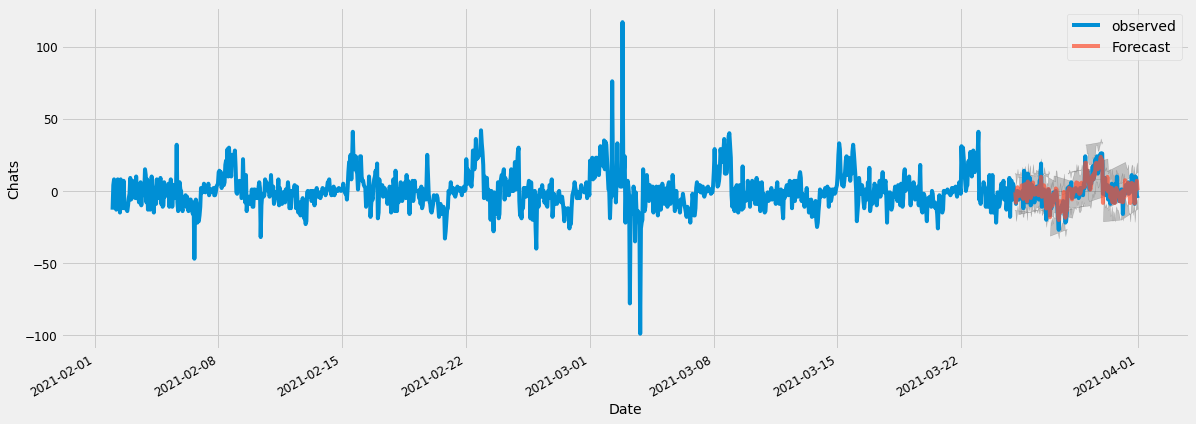

In [68]:
pred1 = results1.get_prediction(start=pd.to_datetime('2021-03-25 06:30:00'), dynamic=False)
pred_ci1 = pred1.conf_int()
ax1 = ChatData['AdjVol'].plot(label='observed')
pred1.predicted_mean.plot(ax=ax1, label='Forecast', alpha=.7, figsize=(18, 7))
ax1.fill_between(pred_ci1.index,
                pred_ci1.iloc[:, 0],
                pred_ci1.iloc[:, 1], color='k', alpha=.2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Chats')
plt.legend()
plt.show()

In [69]:
calls_forecasted = pred.predicted_mean
calls_true = CallData.AdjVol['2021-03-25 06:30:00':]
mse = ((calls_forecasted - calls_true) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 8.87
The Root Mean Squared Error is 2.98


In [70]:
chats_forecasted = pred1.predicted_mean
chats_true = ChatData.AdjVol['2021-03-25 06:30:00':]
mse = ((chats_forecasted - chats_true) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 21.55
The Root Mean Squared Error is 4.64


In [71]:
calls_forecasted = calls_forecasted.to_frame()
calls_forecasted = calls_forecasted.reset_index()

chats_forecasted = chats_forecasted.to_frame()
chats_forecasted = chats_forecasted.reset_index()

In [72]:
CallOutput = CallData.CallVolume.iloc[-192:-168]
CallOutput = CallOutput.reset_index()

ChatOutput = ChatData.ChatVolume.iloc[-192:-168]
ChatOutput = ChatOutput.reset_index()

In [73]:
num_rows = calls_forecasted['predicted_mean'].size
for i in range(num_rows):
  CallOutput = CallOutput.append([{
      'DateTime' :  calls_forecasted.iloc[i,0],
      'CallVolume' : max(0, CallOutput.iloc[i,1] + calls_forecasted.iloc[i,1])
  }])

for i in range(num_rows):
  ChatOutput = ChatOutput.append([{
      'DateTime' :  chats_forecasted.iloc[i,0],
      'ChatVolume' : max(0, ChatOutput.iloc[i,1] + chats_forecasted.iloc[i,1])
  }])


In [74]:
CallOutput = CallOutput.iloc[24:]
ChatOutput = ChatOutput.iloc[24:]

In [76]:
predVolume = pd.concat([CallOutput, ChatOutput['ChatVolume']], axis = 1)
predVolume

,DateTime,CallVolume,ChatVolume
0,2021-03-25 06:30:00,2.25507,10.2068
0,2021-03-25 07:30:00,1.35901,6.72875
0,2021-03-25 08:30:00,2.2894,8.94092
0,2021-03-25 09:30:00,3.19959,13.0588
0,2021-03-25 10:30:00,2.37141,15.8938
...,...,...,...
0,2021-03-31 01:30:00,14.3389,38.3617
0,2021-03-31 02:30:00,0.892976,19.143
0,2021-03-31 03:30:00,10.9384,9.88293
0,2021-03-31 04:30:00,4.68676,10.0875


In [79]:
finalVolume = pd.DataFrame(columns=['DateTime', 'CallVolume', 'ChatVolume'])
num_rows = predVolume['ChatVolume'].size
for itr in range(num_rows):
  finalVolume = finalVolume.append([{
      'DateTime': predVolume.iloc[itr, 0],
      'CallVolume': round(predVolume.iloc[itr, 1]),
      'ChatVolume': round(predVolume.iloc[itr, 2])
  }])
finalVolume.reset_index(drop=True, inplace=True)
finalVolume

,DateTime,CallVolume,ChatVolume
0,2021-03-25 06:30:00,2,10
1,2021-03-25 07:30:00,1,7
2,2021-03-25 08:30:00,2,9
3,2021-03-25 09:30:00,3,13
4,2021-03-25 10:30:00,2,16
...,...,...,...
163,2021-03-31 01:30:00,14,38
164,2021-03-31 02:30:00,1,19
165,2021-03-31 03:30:00,11,10
166,2021-03-31 04:30:00,5,10


#Queueing Simulation

In [80]:
import random

######################
# Tune Parameters As #
##### Required #######
######################
numOfSimulations = 100
avgCallHandlingTime = 14
avgChatHandlingTime = 23
targetCallAnsweringTime = 1/3
targetChatAnsweringTime = 1
targetCallServiceLevel = 0.8
targetChatServiceLevel = 0.8
maxOccupancy = 0.85
maxEmployees = 200
shrinkage = 0.25

#Necessary Functions

In [87]:
def retExponential(vol):
    return random.expovariate(vol/60)

def allocateEmployee(employeeClocks, inTime):
    employeeItr = 0
    minClock = employeeClocks[0]
    for i in range(len(employeeClocks)):
        if employeeClocks[i] < minClock:
            minClock = employeeClocks[i]
            employeeItr = i
    wait = max(minClock - inTime, 0)
    return wait, employeeItr

def generateTimePoints(volume):
    l = []
    if volume == 0:
      return l
    t = 0
    while t <= 60:
        t1 = retExponential(volume)
        if t+t1 > 60:
            break
        t += t1
        l.append(t)
    return l

#Simulation Function

In [88]:
def calculateEmployees(callVolume, chatVolume):
    requiredEmployees = 0
    for i in range(numOfSimulations):
        callList = generateTimePoints(callVolume)
        chatList = generateTimePoints(chatVolume)
        callList.append(120)
        chatList.append(120)
        
        employees = 1
        while employees < maxEmployees:
            callWaitTimeList = []
            chatWaitTimeList = []
            handlingTimeList = []
            employeeClocks = [0]*employees
            
            i, j = 0, 0
            while i < len(callList) - 1 or j < len(chatList) - 1:
                if callList[i] < chatList[j]:
                    wait, itr = allocateEmployee(employeeClocks, callList[i])
                    callWaitTimeList.append(wait)
                    handlingTime = retExponential(60.0/avgCallHandlingTime)
                    handlingTimeList.append(handlingTime)
                    employeeClocks[itr] = callList[i] + wait + handlingTime
                    i += 1
                else:
                    wait, itr = allocateEmployee(employeeClocks, chatList[j])
                    chatWaitTimeList.append(wait)
                    handlingTime = retExponential(60.0/avgChatHandlingTime)
                    handlingTimeList.append(handlingTime)
                    employeeClocks[itr] = chatList[j] + wait + handlingTime
                    j += 1
            
            totalWorkingTime = 0
            for clockTime in employeeClocks:
                totalWorkingTime += clockTime
            NetWorkingTime = totalWorkingTime/employees
            if NetWorkingTime > 60:
                employees += 1
                continue
            
            checkCallServiceLevel = 0
            if len(callWaitTimeList):
                for waitTime in callWaitTimeList:
                    if waitTime <= targetCallAnsweringTime:
                        checkCallServiceLevel += 1
                checkCallServiceLevel /= len(callWaitTimeList)
            else:
                checkCallServiceLevel = 1
            
            checkChatServiceLevel = 0
            if len(chatWaitTimeList):
                for waitTime in chatWaitTimeList:
                    if waitTime <= targetChatAnsweringTime:
                        checkChatServiceLevel += 1
                checkChatServiceLevel /= len(chatWaitTimeList)
            else:
                checkChatServiceLevel = 1
            
            totalHandlingTime = 0
            for handlingTime in handlingTimeList:
                totalHandlingTime += handlingTime
            avgOccupancy = totalHandlingTime/employees
            if avgOccupancy > maxOccupancy*60:
                employees += 1
                continue
            
            if checkCallServiceLevel >= targetCallServiceLevel and checkChatServiceLevel >= targetChatServiceLevel:
                break
            employees += 1
        requiredEmployees += employees
    
    requiredEmployees /= numOfSimulations
    
    requiredEmployees /= (1-shrinkage)
    return requiredEmployees

#Hourly Prediction

In [95]:
predEmployees = pd.DataFrame(columns=['DateTime', 'Call Volume', 'Chat Volume', 'Employees'])
num_rows = finalVolume['CallVolume'].size
for i in range(num_rows):
    predEmployees = predEmployees.append([{
        'DateTime': finalVolume.iloc[i, 0],
        'Call Volume': finalVolume.iloc[i, 1],
        'Chat Volume': finalVolume.iloc[i, 2],
        'Employees': np.ceil(calculateEmployees(finalVolume.iloc[i, 1], finalVolume.iloc[i, 2]))
    }])

In [109]:
print('Hourly Requirement of Employees for the Last Week of March : ')
predEmployees

Hourly Requirement of Employees for the Last Week of March : 


,DateTime,Call Volume,Chat Volume,Employees
0,2021-03-25 06:30:00,2,10,11.0
0,2021-03-25 07:30:00,1,7,8.0
0,2021-03-25 08:30:00,2,9,12.0
0,2021-03-25 09:30:00,3,13,15.0
0,2021-03-25 10:30:00,2,16,18.0
...,...,...,...,...
0,2021-03-31 01:30:00,14,38,49.0
0,2021-03-31 02:30:00,1,19,20.0
0,2021-03-31 03:30:00,11,10,18.0
0,2021-03-31 04:30:00,5,10,14.0


#Daily Prediction

In [108]:
shiftRequirement = pd.DataFrame(columns = ['Date', 'Shift', 'Employees'])
itr = 0
numOfRows = predEmployees['Employees'].size
while itr < numOfRows-1:
    temp = predEmployees.iloc[itr:itr+9, :]
    shiftRequirement = shiftRequirement.append([{
        'Date': temp.iloc[0, 0].date(),
        'Shift': 'Morning',
        'Employees': temp['Employees'].max()
    }])
    itr += 9
    
    temp = predEmployees.iloc[itr:itr+8, :]
    shiftRequirement = shiftRequirement.append([{
        'Date': temp.iloc[0, 0].date(),
        'Shift': 'Afternoon',
        'Employees': temp['Employees'].max()
    }])
    itr += 8
    
    temp = predEmployees.iloc[itr:itr+7, :]
    shiftRequirement = shiftRequirement.append([{
        'Date': temp.iloc[0, 0].date(),
        'Shift': 'Night',
        'Employees': temp['Employees'].max()
    }])
    itr += 7

print('Shiftwise Requirement for the Last Week of March : ')
shiftRequirement

Shiftwise Requirement for the Last Week of March : 


,Date,Shift,Employees
0,2021-03-25,Morning,28.0
0,2021-03-25,Afternoon,33.0
0,2021-03-25,Night,26.0
0,2021-03-26,Morning,25.0
0,2021-03-26,Afternoon,28.0
0,2021-03-26,Night,26.0
0,2021-03-27,Morning,17.0
0,2021-03-27,Afternoon,14.0
0,2021-03-27,Night,15.0
0,2021-03-28,Morning,21.0


In [107]:
dailyRequirement = pd.DataFrame(columns = ['Date', 'Employees'])
numOfRows = shiftRequirement['Employees'].size
itr = 0
while itr < numOfRows:
    dailyRequirement = dailyRequirement.append([{
        'Date': shiftRequirement.iloc[itr, 0],
        'Employees': shiftRequirement.iloc[itr, 2] + shiftRequirement.iloc[itr+1, 2] + shiftRequirement.iloc[itr+2, 2]
    }])
    itr += 3
print('The Daily Requirement for the Last Week of March : ')
dailyRequirement

The Daily Requirement for the Last Week of March : 


,Date,Employees
0,2021-03-25,87.0
0,2021-03-26,79.0
0,2021-03-27,46.0
0,2021-03-28,58.0
0,2021-03-29,132.0
0,2021-03-30,132.0
0,2021-03-31,139.0


#Weekly/Monthly Requirement

In [106]:
import statistics

itr_list = [0, 1, 2, 3, 4, 5, 6]
weeklyData = []
numOfRows = dailyRequirement['Employees'].size
for itr in itr_list:
    temp = []
    while itr < numOfRows:
        temp.append(dailyRequirement.iloc[itr, 1])
        itr += 7
    weeklyData.append(statistics.median(temp))
monthlyRequirement = 0
for data in weeklyData:
    monthlyRequirement += data
monthlyRequirement /= 5
print('Number of employees reuired on Monthly/Weekly Basis : ', np.ceil(monthlyRequirement))

Number of employees reuired on Monthly/Weekly Basis :  135.0


# Conclusion
The model attempts to replicate a close to real life estimate of the WAITING TIME  as well as the  SERVER OCCUPANCY  both of which are very important factors for predicting the number of employees.

We have implemented a predictive model which incorporates Time Series Forecasting and Simulation Techniques to predict the optimum number of Employees required at a remote IT Service Desk to achieve the desired service level.

With new data available every passing month, the model can be retrained, and the hyperparameters can be recalibrated for more accurate results.